In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from SharedX import ShareXaxis
from UniversalColor import UniversalColor
from legend_shadow import legend_shadow
from scipy.io import readsav
import spiceypy as spice

import JupiterMag as jm
import Leadangle_wave as LeadA

import os

UC = UniversalColor()
UC.set_palette()

Importing Library
done


In [77]:
target = 'Ganymede'
TEB_included = False

In [78]:
PJ_start = 0
PJ_end = 43
fig_title = target+' PJ'+str(PJ_start+1).zfill(2)+'-PJ'+str(PJ_end)
print(fig_title)

Ganymede PJ01-PJ43


In [79]:
# データサイズを調べる
datasize = 0

for i in np.arange(PJ_start,PJ_end,1,dtype=int):
    i += 1
    if i == 2:
        continue
    if i < 10:
        PJ = 'PJ0'+str(i)
    else:
        PJ = 'PJ'+str(i)
        
    savpath = '/Users/shin/Documents/Research/Juno/UVS/Satellite_Footpaths_Shin/Output_v2_PaperHue2023/'+PJ+'/'+target[0]+'FP_info_v900km_fixed.sav'
    if os.path.isfile(savpath):
        savdata = readsav(savpath)
    else:
        continue

    variable = savdata['fp_info']

    # 'MIDTIME_ET'を用いてスライス位置を決定する
    MIDTIME_ET = np.array(variable['MIDTIME_ET'][0])
    idx = np.where(MIDTIME_ET>0)

    datasize += idx[0].size

print(datasize)

561


In [80]:
# データの読み込み
lon_MAW_arr = np.zeros(datasize)
lon_TEB_arr = np.zeros(datasize)
err_lon_MAW_arr = np.zeros(datasize)
err_lon_TEB_arr = np.zeros(datasize)
lat_MAW_arr = np.zeros(datasize)
lat_TEB_arr = np.zeros(datasize)
err_lat_MAW_arr = np.zeros(datasize)
err_lat_TEB_arr = np.zeros(datasize)
moon_s3long_arr = np.zeros(datasize)
moon_s3long_M_arr = np.zeros(datasize)
moon_s3long_T_arr = np.zeros(datasize)
et_arr = np.zeros(datasize)
hemisphere_arr = [None]*datasize
pj_num_arr = np.zeros(datasize)

start = 0
for i in np.arange(PJ_start,PJ_end,1,dtype=int):
    i += 1
    if i == 2:
        continue
    if i < 10:
        PJ = 'PJ0'+str(i)
    else:
        PJ = 'PJ'+str(i)
    
    savpath = '/Users/shin/Documents/Research/Juno/UVS/Satellite_Footpaths_Shin/Output_v2_PaperHue2023/'+PJ+'/'+target[0]+'FP_info_v900km_fixed.sav'
    if os.path.isfile(savpath):
        savdata = readsav(savpath)
    else:
        continue
    
    variable = savdata['fp_info']

    # 'MIDTIME_ET'を用いてスライス位置を決定する
    MIDTIME_ET = np.array(variable['MIDTIME_ET'][0])
    idx = np.where(MIDTIME_ET>0)
    end = start+idx[0].size

    lon_MAW_arr[start:end] = np.array(variable['LON_MAW'][0])[idx]
    lon_TEB_arr[start:end] = np.array(variable['LON_TEB'][0])[idx]
    err_lon_MAW_arr[start:end] = np.array(variable['LON_MAW_ERROR'][0])[idx]
    err_lon_TEB_arr[start:end] = np.array(variable['LON_TEB_ERROR'][0])[idx]
    lat_MAW_arr[start:end] = np.array(variable['LAT_MAW'][0])[idx]
    lat_TEB_arr[start:end] = np.array(variable['LAT_TEB'][0])[idx]
    err_lat_MAW_arr[start:end] = np.array(variable['LAT_MAW_ERROR'][0])[idx]
    err_lat_TEB_arr[start:end] = np.array(variable['LAT_TEB_ERROR'][0])[idx]
    moon_s3long_arr[start:end] = np.array(variable['SIII_LON'][0])[idx]
    moon_s3long_M_arr[start:end] = np.array(variable['SIII_LON'][0])[idx]
    moon_s3long_T_arr[start:end] = np.array(variable['SIII_LON'][0])[idx]
    et_arr[start:end] = np.array(variable['MIDTIME_ET'][0])[idx]
    hemisphere_arr[start:end] = variable['HEMISPHERE'][0][idx]
    pj_num_arr[start:end] = i

    start = end

# データがない部分はnp.nanで置き換える (MAW)
nonumber = np.where((lon_MAW_arr<-100))
moon_s3long_arr[nonumber] = np.nan
moon_s3long_M_arr[nonumber] = np.nan
lon_MAW_arr[nonumber] = np.nan 
err_lon_MAW_arr[nonumber] = np.nan
lat_MAW_arr[nonumber] = np.nan 
err_lat_MAW_arr[nonumber] = np.nan
# pj_num_arr[nonumber] = np.nan

# データがない部分はnp.nanで置き換える (TEB)
nonumber = np.where((lon_TEB_arr<-100))
moon_s3long_T_arr[nonumber] = np.nan
lon_TEB_arr[nonumber] = np.nan 
err_lon_TEB_arr[nonumber] = np.nan
lat_TEB_arr[nonumber] = np.nan 
err_lat_TEB_arr[nonumber] = np.nan
# pj_num_arr[nonumber] = np.nan

if TEB_included:
    nonumber = np.where((lon_MAW_arr<-100)|(lon_TEB_arr<-100))

# for i in nonumber[0]:
#     hemisphere_arr[i] = b'NaN'

In [66]:
spice.furnsh('/Users/shin/Documents/Research/Jupiter/Codes/HST/kernel/cassMetaK.txt')
et_hst = spice.str2et('2014-01-16T00:00:00')
print(et_hst)

443102467.18435526


In [67]:
def moonS3wlon(et:float, MOON:str):
    # Juno's position seen from Jupiter in IAU_JUPITER coordinate.
    _, lightTimes = spice.spkpos(
        targ='JUNO', et=et, ref='IAU_JUPITER', abcorr='LT+S', obs='JUPITER'
    )

    # Moon's position seen from Jupiter in IAU_JUPITER coordinate.
    pos, _ = spice.spkpos(
        targ=MOON, et=et, ref='IAU_JUPITER', abcorr='none', obs='JUPITER'
    )

    posx, posy, posz = pos[0], pos[1], pos[2]
    posr = np.sqrt(posx**2 + posy**2 + posz**2)
    # postheta = np.arccos(posz/posr)
    posphi = np.arctan2(posy, posx)
    if posphi < 0:
        Sys3 = np.degrees(-posphi)
    else:
        Sys3 = np.degrees(2*np.pi - posphi)

    return Sys3

In [53]:
savpath = "/Users/shin/Documents/Research/Juno/UVS/Codes/data/Satellite_FP_JRM33.sav"
data = readsav(savpath)
print(type(data))
print(data.keys())
variable = data['gfp_contour_n']

print(variable[1500:1510])
# >>> Satellite S3 w-longitude, Footprint S3 w-longitude, Footprint latitude

# print(variable[1500:1600][:,0])

<class 'scipy.io._idl.AttrDict'>
dict_keys(['ifp_contour_n', 'ifp_contour_s', 'efp_contour_n', 'efp_contour_s', 'gfp_contour_n', 'gfp_contour_s', 'cfp_contour_s_kk', 'cfp_contour_s_con2020', 'cfp_contour_n_kk', 'cfp_contour_n_con2020'])
[[ 75.       140.13      63.929996]
 [ 75.05     140.14188   63.915646]
 [ 75.1      140.15373   63.90129 ]
 [ 75.15     140.16557   63.886936]
 [ 75.200005 140.17741   63.872578]
 [ 75.25     140.18924   63.858223]
 [ 75.3      140.20105   63.843864]
 [ 75.35     140.21284   63.829506]
 [ 75.4      140.22462   63.815147]
 [ 75.450005 140.2364    63.800785]]


In [54]:
def S3EQ(fpwlon, fplat, hemisphere, MOON: str):
    """_summary_

    Args:
        fpwlon: System III longitude of footprint aurora at Jupiter's upper atmosphere [deg]
        satmodel: footprint model from magnetic field model
        MOON: select from IO, EUROPA, GANYMEDE

    Returns:
        y: System III longitude of instantaneous field line at the orbital plane
    """

    if hemisphere == b'North':
        satmodel = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
    elif hemisphere == b'South':
        satmodel = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
    else:
        # print('Hemisphere not found')
        return np.nan

    # eqwlon = satmodel.wlon[:-1]     # Satellite System III longitude at the equator

    savpath = "/Users/shin/Documents/Research/Juno/UVS/Codes/data/Satellite_FP_JRM33.sav"
    data = readsav(savpath)

    if (MOON == 'IO') or (MOON == 'Io'):
        s3wlon = satmodel.iowlon[:-1]
        s3lat = satmodel.galat[:-1]
        data_name = 'ifp_contour'

    elif (MOON == 'EUROPA') or (MOON == 'Europa'):
        s3wlon = satmodel.euwlon[:-1]
        s3lat = satmodel.galat[:-1]
        data_name = 'efp_contour'

    elif (MOON == 'GANYMEDE') or (MOON == 'Ganymede'):
        s3wlon = satmodel.gawlon[:-1]
        s3lat = satmodel.galat[:-1]
        data_name = 'gfp_contour'

    if hemisphere == b'North':
        variable = data[data_name+'_n']
        eqwlon = variable[0:-1][:,0]
        s3wlon = variable[0:-1][:,1]
        s3lat = variable[0:-1][:,2]

    elif hemisphere == b'South':
        variable = data[data_name+'_s']
        eqwlon = variable[0:-1][:,0]
        s3wlon = variable[0:-1][:,1]
        s3lat = variable[0:-1][:,2]

        """
        if hemisphere == b'North':
            if fplat > 80:
                slice_idx = np.where(s3lat>80)
                s3wlon = s3wlon[slice_idx]
                eqwlon = eqwlon[slice_idx]
            elif (fplat <= 80) and (fplat > 60):
                slice_idx = np.where((s3lat<=80)&(s3lat>60))
                s3wlon = s3wlon[slice_idx]
                eqwlon = eqwlon[slice_idx]
            else:
                slice_idx = np.where(s3lat<=60)
                s3wlon = s3wlon[slice_idx]
                eqwlon = eqwlon[slice_idx]
        """

    # Search the System III index
    distance = (s3wlon[:-1]-fpwlon)**2 + (s3lat[:-1]-fplat)**2
    
    argsorted = np.argsort(distance, axis=0)
    # s3_idx0, s3_idx1 = argsorted[0], argsorted[1]

    s3_idx0 = argsorted[0]
    s3wlon0 = s3wlon[s3_idx0]
    eqwlon0 = eqwlon[s3_idx0]

    """
    if s3_idx0 == 0:
        if abs(s3wlon[1]-fpwlon) > abs(s3wlon[-2]-fpwlon):
            s3_idx1 = -2
        else:
            s3_idx1 = 1
    elif s3_idx0 == s3wlon.size-1:
        if abs(s3wlon[0]-fpwlon) > abs(s3wlon[s3_idx0-1]-fpwlon):
            s3_idx1 = s3_idx0-1
        else:
            s3_idx1 = 0
    else:
        if abs(s3wlon[s3_idx0+1]-fpwlon) > abs(s3wlon[s3_idx0-1]-fpwlon):
            s3_idx1 = s3_idx0-1
        else:
            s3_idx1 = s3_idx0+1
    """

    s3_idx1 = argsorted[1]
    s3wlon1 = s3wlon[s3_idx1]
    eqwlon1 = eqwlon[s3_idx1]

    x = fpwlon
    x0 = s3wlon0
    x1 = s3wlon1
    y0 = eqwlon0
    y1 = eqwlon1

    # print(x0, x1, y0, y1)

    if y0-y1 > 180:
        y1 += 360
    elif y1-y0 > 180:
        y0 += 360

    y = ((y1-y0)/(x1-x0))*(x-x0) + y0

    if y > 360:
        y += -360
    elif y < 0:
        y += 360

    return eqwlon0

In [55]:
# JRM33
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

In [56]:
MAW_eq_arr = np.zeros(datasize)
MAW_eq_arr_0 = np.zeros(datasize)
MAW_eq_arr_1 = np.zeros(datasize)
d_MAW_eq_arr = np.zeros(datasize)
d_MAW_eq_arr_0 = np.zeros(datasize)
d_MAW_eq_arr_1 = np.zeros(datasize)
TEB_eq_arr = np.zeros(datasize)
TEB_eq_arr_0 = np.zeros(datasize)
TEB_eq_arr_1 = np.zeros(datasize)
d_TEB_eq_arr = np.zeros(datasize)
d_TEB_eq_arr_0 = np.zeros(datasize)
d_TEB_eq_arr_1 = np.zeros(datasize)
moon_eq_spice = np.zeros(datasize)

for i in range(datasize):
    moon_eq_spice[i] = moonS3wlon(et=et_arr[i], MOON=target)
    MAW_eq_arr[i] = S3EQ(lon_MAW_arr[i], lat_MAW_arr[i], hemisphere_arr[i], MOON=target)
    MAW_eq_arr_0[i] = S3EQ(lon_MAW_arr[i]+err_lon_MAW_arr[i], lat_MAW_arr[i], hemisphere_arr[i], MOON=target)
    MAW_eq_arr_1[i] = S3EQ(lon_MAW_arr[i]-err_lon_MAW_arr[i], lat_MAW_arr[i], hemisphere_arr[i], MOON=target)
    d_MAW_eq_arr[i] = moon_eq_spice[i]-MAW_eq_arr[i]
    d_MAW_eq_arr_0[i] = MAW_eq_arr_0[i]-MAW_eq_arr[i]
    d_MAW_eq_arr_1[i] = MAW_eq_arr[i]-MAW_eq_arr_1[i]

    TEB_eq_arr[i] = S3EQ(lon_TEB_arr[i], lat_TEB_arr[i], hemisphere_arr[i], MOON=target)
    TEB_eq_arr_0[i] = S3EQ(lon_TEB_arr[i]+err_lon_TEB_arr[i], lat_TEB_arr[i], hemisphere_arr[i], MOON=target)
    TEB_eq_arr_1[i] = S3EQ(lon_TEB_arr[i]-err_lon_TEB_arr[i], lat_TEB_arr[i], hemisphere_arr[i], MOON=target)
    d_TEB_eq_arr[i] = moon_eq_spice[i]-TEB_eq_arr[i]
    d_TEB_eq_arr_0[i] = TEB_eq_arr_0[i]-TEB_eq_arr[i]
    d_TEB_eq_arr_1[i] = TEB_eq_arr[i]-TEB_eq_arr_1[i]

    # print(i)
    if d_MAW_eq_arr[i] < 0:
        d_MAW_eq_arr[i] += 360.
    if d_TEB_eq_arr[i] < 0:
        d_TEB_eq_arr[i] += 360.
    if d_MAW_eq_arr_0[i] < 0:
        print(i)
        # d_MAW_eq_arr_0[i] = np.nan
    if d_MAW_eq_arr_1[i] < 0:
        print('   ', i)
        # d_MAW_eq_arr_0[i] = np.nan
    if d_MAW_eq_arr_1[i] > 5:
        print(i)

# データがない部分はnp.nanで置き換える
MAW_eq_arr[nonumber] = np.nan
MAW_eq_arr_0[nonumber] = np.nan
MAW_eq_arr_1[nonumber] = np.nan
d_MAW_eq_arr[nonumber] = np.nan
d_MAW_eq_arr_0[nonumber] = np.nan
d_MAW_eq_arr_1[nonumber] = np.nan
TEB_eq_arr[nonumber] = np.nan
TEB_eq_arr_0[nonumber] = np.nan
TEB_eq_arr_1[nonumber] = np.nan
d_TEB_eq_arr[nonumber] = np.nan
d_TEB_eq_arr_0[nonumber] = np.nan
d_TEB_eq_arr_1[nonumber] = np.nan
moon_eq_spice[nonumber] = np.nan

In [57]:
jdx = 2
print(hemisphere_arr[jdx])
print(lon_MAW_arr[jdx], lat_MAW_arr[jdx], err_lat_MAW_arr[jdx])
print(MAW_eq_arr[jdx], MAW_eq_arr_0[jdx], MAW_eq_arr_1[jdx])
print(d_MAW_eq_arr_0[jdx])

MAW_eq_arr_0[jdx] = S3EQ(lon_MAW_arr[jdx]+err_lon_MAW_arr[jdx], lat_MAW_arr[jdx], hemisphere_arr[jdx], MOON=target)
MAW_eq_arr_1[jdx] = S3EQ(lon_MAW_arr[jdx]-err_lon_MAW_arr[jdx], lat_MAW_arr[jdx], hemisphere_arr[jdx], MOON=target)

b'NaN'
298.58831787109375 -75.63936614990234 0.20333817601203918
nan nan nan
nan


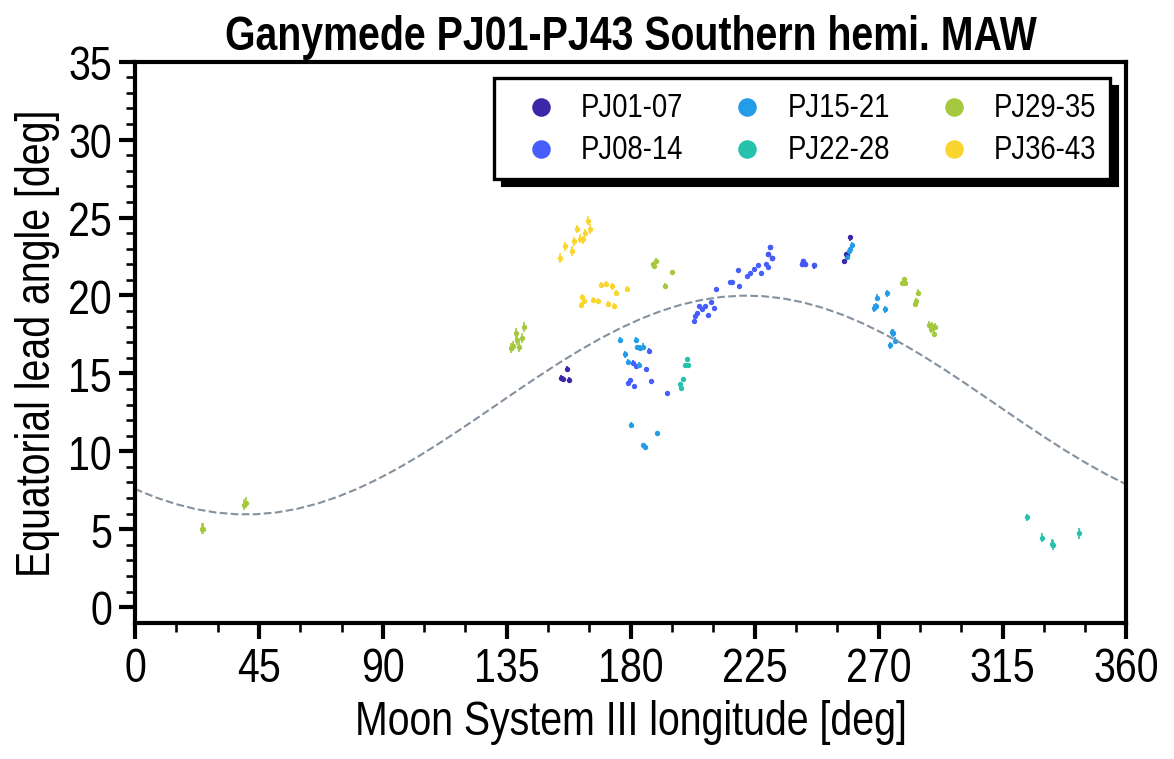

In [58]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8,5), ticksize=1.5,
                dpi='M')
F.initialize()

ymax = 1
if target == 'Io':
    ymax = 12
elif target == 'Europa':
    ymax = 18
elif target == 'Ganymede':
    ymax = 35

F.set_xaxis(label='Moon System III longitude [deg]',
            min=0, max=360,
            ticks=np.arange(0,360+1,45),
            ticklabels=np.arange(0,360+1,45),
            minor_num=3)
F.set_yaxis(ax_idx=0, label='Equatorial lead angle [deg]',
            min=-1, max=ymax,
            ticks=np.arange(0,ymax+1,5),
            ticklabels=np.arange(0,ymax+1,5),
            minor_num=5)

PJ01_07_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr<=8))
pos = PJ01_07_south
sccolor = F._parula_colors()[0]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=2.5, label='PJ01-07')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ08_14_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=8)&(pj_num_arr<=15))
pos = PJ08_14_south
sccolor = F._parula_colors()[45]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=2.5, label='PJ08-14')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ15_21_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=15)&(pj_num_arr<=21))
pos = PJ15_21_south
sccolor = F._parula_colors()[90]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=2.5, label='PJ15-21')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ22_28_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=22)&(pj_num_arr<=28))
pos = PJ22_28_south
sccolor = F._parula_colors()[135]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=2.5, label='PJ22-28')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ29_35_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=29)&(pj_num_arr<=35))
pos = PJ29_35_south
sccolor = F._parula_colors()[180]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=2.5, label='PJ29-35')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ36_43_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=36)&(pj_num_arr<=43))
pos = PJ36_43_south
sccolor = F._parula_colors()[230]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=2.5, label='PJ36-43')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

F.ax.set_title(fig_title+' Southern hemi. MAW', fontsize=F.fontsize, weight='bold')

x = np.linspace(0, 2*3.141592, 50)
if target=='Io':
    y_N = 4.26+2.64*np.cos(x)+0.50*np.sin(x)+0.20*np.cos(2*x)+0.126*np.sin(2*x)
    y_S = 4.14-1.89*np.cos(x)-0.70*np.sin(x)+0.22*np.cos(2*x)-0.12*np.sin(2*x)
if target=='Europa':
    y_N = 5.78+3.29*np.cos(0.99*x)+1.41*np.sin(0.99*x)
    y_S = 7.06-3.37*np.cos(x)+0.15*np.sin(x)
if target=='Ganymede':
    y_N = 12.45+6.16*np.cos(0.98*x)+3.64*np.sin(0.98*x)
    y_S = 12.97-5.39*np.cos(0.99*x)-4.50*np.sin(0.99*x)

F.ax.plot(np.degrees(x), y_S, linestyle='--', linewidth=1, color=UC.gray)

legend = F.legend(ax_idx=0, loc='upper right', ncol=3, markerscale=5, 
                  fontsize_scale=0.7, textcolor=False, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

In [14]:
if TEB_included:
    F = ShareXaxis()
    F.fontsize = 23
    F.fontname = 'Liberation Sans Narrow'

    F.set_figparams(nrows=1, figsize=(8,5), ticksize=1.5,
                    dpi='M')
    F.initialize()

    ymax = 1
    if target == 'Io':
        ymax = 12
    elif target == 'Europa':
        ymax = 18
    elif target == 'Ganymede':
        ymax = 35

    F.set_xaxis(label='Moon System III longitude [deg]',
                min=0, max=360,
                ticks=np.arange(0,360+1,45),
                ticklabels=np.arange(0,360+1,45),
                minor_num=3)
    F.set_yaxis(ax_idx=0, label='Equatorial lead angle [deg]',
                min=-1, max=ymax,
                ticks=np.arange(0,ymax+1,5),
                ticklabels=np.arange(0,ymax+1,5),
                minor_num=5)

    PJ01_07_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr<=8))
    pos = PJ01_07_south
    sccolor = F._parula_colors()[0]
    F.ax.scatter(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                color=sccolor, s=2.5, label='PJ01-07')
    F.ax.errorbar(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                yerr=np.array([d_TEB_eq_arr_0[pos], 
                                d_TEB_eq_arr_1[pos]]),
                linewidth=0., markersize=0,
                elinewidth=0.8, color=sccolor)

    PJ08_14_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=8)&(pj_num_arr<=15))
    pos = PJ08_14_south
    sccolor = F._parula_colors()[45]
    F.ax.scatter(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                color=sccolor, s=2.5, label='PJ08-14')
    F.ax.errorbar(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                yerr=np.array([d_TEB_eq_arr_0[pos], 
                                d_TEB_eq_arr_1[pos]]),
                linewidth=0., markersize=0,
                elinewidth=0.8, color=sccolor)

    PJ15_21_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=15)&(pj_num_arr<=21))
    pos = PJ15_21_south
    sccolor = F._parula_colors()[90]
    F.ax.scatter(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                color=sccolor, s=2.5, label='PJ15-21')
    F.ax.errorbar(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                yerr=np.array([d_TEB_eq_arr_0[pos], 
                                d_TEB_eq_arr_1[pos]]),
                linewidth=0., markersize=0,
                elinewidth=0.8, color=sccolor)

    PJ22_28_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=22)&(pj_num_arr<=28))
    pos = PJ22_28_south
    sccolor = F._parula_colors()[135]
    F.ax.scatter(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                color=sccolor, s=2.5, label='PJ22-28')
    F.ax.errorbar(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                yerr=np.array([d_TEB_eq_arr_0[pos], 
                                d_TEB_eq_arr_1[pos]]),
                linewidth=0., markersize=0,
                elinewidth=0.8, color=sccolor)

    PJ29_35_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=29)&(pj_num_arr<=35))
    pos = PJ29_35_south
    sccolor = F._parula_colors()[180]
    F.ax.scatter(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                color=sccolor, s=2.5, label='PJ29-35')
    F.ax.errorbar(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                yerr=np.array([d_TEB_eq_arr_0[pos], 
                                d_TEB_eq_arr_1[pos]]),
                linewidth=0., markersize=0,
                elinewidth=0.8, color=sccolor)

    PJ36_43_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=36)&(pj_num_arr<=43))
    pos = PJ36_43_south
    sccolor = F._parula_colors()[230]
    F.ax.scatter(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                color=sccolor, s=2.5, label='PJ36-43')
    F.ax.errorbar(moon_s3long_arr[pos], d_TEB_eq_arr[pos], 
                yerr=np.array([d_TEB_eq_arr_0[pos], 
                                d_TEB_eq_arr_1[pos]]),
                linewidth=0., markersize=0,
                elinewidth=0.8, color=sccolor)

    F.ax.set_title(fig_title+' Southern hemi. TEB', fontsize=F.fontsize, weight='bold')

    x = np.linspace(0, 2*3.141592, 50)
    if target=='Io':
        y_N = 4.26+2.64*np.cos(x)+0.50*np.sin(x)+0.20*np.cos(2*x)+0.126*np.sin(2*x)
        y_S = 4.14-1.89*np.cos(x)-0.70*np.sin(x)+0.22*np.cos(2*x)-0.12*np.sin(2*x)
    if target=='Europa':
        y_N = 5.78+3.29*np.cos(0.99*x)+1.41*np.sin(0.99*x)
        y_S = 7.06-3.37*np.cos(x)+0.15*np.sin(x)
    if target=='Ganymede':
        y_N = 12.45+6.16*np.cos(0.98*x)+3.64*np.sin(0.98*x)
        y_S = 12.97-5.39*np.cos(0.99*x)-4.50*np.sin(0.99*x)

    F.ax.plot(np.degrees(x), y_N, linestyle='--', linewidth=1, color=UC.gray)

    legend = F.legend(ax_idx=0, loc='upper right', ncol=3, markerscale=5, 
                    fontsize_scale=0.7, textcolor=False, handletextpad=0.2)
    legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

In [15]:
# 定数
RJ = 71492*1E+3  # Jupiter radius [m]
RE = 1560*1E+3   # Europa radius [m]
OMG_J = 2*np.pi/(9.55*3600)  # Angular velocity of Jupiter System III rotation [rad sec-1] 
OMG_G = 2*np.pi/(7.2*24*3600)   # Ganymede orbital angular velosity [rad/sec]

Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
Psyn_ga = (10.53)*3600      # Moon's synodic period [sec]

Hp0 = 0.64*RJ        # H0 [m] (Bagenal&Delamere2011)

jm.Internal.Config(Model='jrm33', CartesianIn=True, CartesianOut=True)
jm.Con2020.Config(equation_type='analytic')

{'mu_i': 139.6,
 'i_rho': 16.7,
 'r0': 7.8,
 'r1': 51.4,
 'd': 3.6,
 'xt': 9.3,
 'xp': 155.8,
 'Edwards': True,
 'error_check': True,
 'CartesianIn': True,
 'CartesianOut': True,
 'equation_type': 'analytic',
 'Smooth': False,
 'DeltaRho': 1.0,
 'DeltaZ': 0.1,
 'g': 417659.3836476442,
 'azfunc': 'connerney',
 'wO_open': 0.1,
 'wO_om': 0.35,
 'thetamm': 16.1,
 'dthetamm': 0.5,
 'thetaoc': 10.716,
 'dthetaoc': 0.125}

リード角モデル計算

$V_A = \frac{B}{\sqrt{\mu_0 n_{\rm i} A_{\rm i}}}$

$H_{\rm p} = 0.64\sqrt{\frac{T_{\rm i}}{A_{\rm i}} \left(1+Z_{\rm i}\frac{T_{\rm e}}{T_{\rm i}} \right)}$


In [16]:
# Jia & Kivelson (2021)のパラメータ
ni = 4.0     # ion number density [cm-3] range (1-8) (Jia & Kivelson 2021)
Zi = 1.3     # ion average charge                    (Jia & Kivelson 2021)
Ai = 14      # ion mass [amu]                        (Jia & Kivelson 2021)
Ti = 60      # ion temperature [eV]                  (Jia & Kivelson 2021)
Te = 300     # electron temperature [eV]             (Jia & Kivelson 2021)


In [17]:
# 結果初期化
moon_s3wlon = np.radians(np.linspace(-20,380,60))
tau_arr = np.zeros(moon_s3wlon.shape)
mass_dens_arr = np.zeros(moon_s3wlon.shape)
OMGR = 2*np.pi/(Psyn_ga)    # Moon's synodic angular velocity [rad/sec]

# パラメータ調整

# 中心質量密度とスケールハイトのリセット
RHO0 = ni*Ai # [amu cm-3]
HP = Hp0*np.sqrt((Ti/Ai)*(1+Zi*(Te/Ti)))     # [m] (Steffl+2004)
print('Scale height [RJ]:', HP/RJ)

if target=='Io':
    target_RJ = 5.9*RJ
elif target=='Europa':
    target_RJ = 9.38*RJ
elif target=='Ganymede':
    target_RJ = 15.0*RJ

# モデル計算
for i in range(moon_s3wlon.size):
    S0 = LeadA.Awave().tracefield(target_RJ, moon_s3wlon[i])
    tau, theta, Va, mass_dens = LeadA.Awave().tracefield2(target_RJ,
                                                    moon_s3wlon[i],
                                                    S0, 
                                                    RHO0, 
                                                    HP, 
                                                    'S')
    tau_arr[i] = tau
    mass_dens_arr[i] = mass_dens

eq_lead_SMAW = np.degrees(OMGR*tau_arr)

n_moon_s3wlon = np.linspace(0,360,50)  # [deg]
n_eq_lead_SMAW = np.interp(n_moon_s3wlon, np.degrees(moon_s3wlon)+eq_lead_SMAW, eq_lead_SMAW)

Scale height [RJ]: 3.6284589408885815


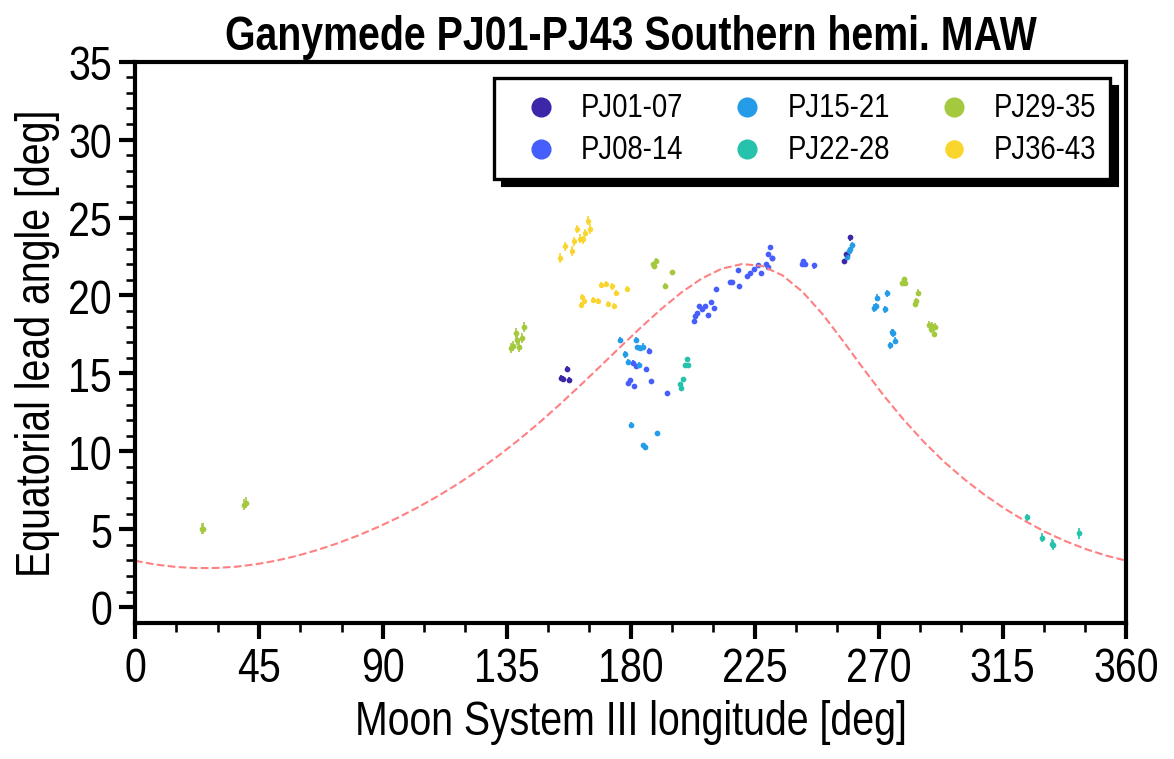

In [18]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8,5), ticksize=1.5,
                dpi='M')
F.initialize()

ymax = 1
if target == 'Io':
    ymax = 12
elif target == 'Europa':
    ymax = 18
elif target == 'Ganymede':
    ymax = 35

F.set_xaxis(label='Moon System III longitude [deg]',
            min=0, max=360,
            ticks=np.arange(0,360+1,45),
            ticklabels=np.arange(0,360+1,45),
            minor_num=3)
F.set_yaxis(ax_idx=0, label='Equatorial lead angle [deg]',
            min=-1, max=ymax,
            ticks=np.arange(0,ymax+1,5),
            ticklabels=np.arange(0,ymax+1,5),
            minor_num=5)

PJ01_07_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr<=7))
pos = PJ01_07_south
sccolor = F._parula_colors()[0]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ01-07')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ08_14_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=8)&(pj_num_arr<=14))
pos = PJ08_14_south
sccolor = F._parula_colors()[45]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ08-14')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ15_21_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=15)&(pj_num_arr<=21))
pos = PJ15_21_south
sccolor = F._parula_colors()[90]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ15-21')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ22_28_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=22)&(pj_num_arr<=28))
pos = PJ22_28_south
sccolor = F._parula_colors()[135]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ22-28')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ29_35_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=29)&(pj_num_arr<=35))
pos = PJ29_35_south
sccolor = F._parula_colors()[180]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ29-35')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ36_43_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=36)&(pj_num_arr<=43))
pos = PJ36_43_south
sccolor = F._parula_colors()[230]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=2.5, label='PJ36-43')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

F.ax.set_title(fig_title+' Southern hemi. MAW', fontsize=F.fontsize, weight='bold')

# Model calculation
F.ax.plot(n_moon_s3wlon, n_eq_lead_SMAW, 
          linestyle='--', linewidth=1, color=UC.pink)

legend = F.legend(ax_idx=0, loc='upper right', ncol=3, markerscale=5, 
                  fontsize_scale=0.7, textcolor=False, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

In [19]:
# 結果初期化
moon_s3wlon = np.radians(np.linspace(-20,380,60))
tau_arr = np.zeros(moon_s3wlon.shape)
mass_dens_arr = np.zeros(moon_s3wlon.shape)
OMGR = 2*np.pi/(Psyn_ga)    # Moon's synodic angular velocity [rad/sec]

# パラメータ調整
ni = 8.0     # ion number density [cm-3] range

# 中心質量密度とスケールハイトのリセット
RHO0 = ni*Ai # [amu cm-3]
HP = Hp0*np.sqrt((Ti/Ai)*(1+Zi*(Te/Ti)))     # [m] (Steffl+2004)
print('Scale height [RJ]:', HP/RJ)

if target=='Io':
    target_RJ = 5.9*RJ
elif target=='Europa':
    target_RJ = 9.38*RJ
elif target=='Ganymede':
    target_RJ = 15.0*RJ

# モデル計算
for i in range(moon_s3wlon.size):
    S0 = LeadA.Awave().tracefield(target_RJ, moon_s3wlon[i])
    tau, theta, Va, mass_dens = LeadA.Awave().tracefield2(target_RJ,
                                                    moon_s3wlon[i],
                                                    S0, 
                                                    RHO0, 
                                                    HP, 
                                                    'S')
    tau_arr[i] = tau
    mass_dens_arr[i] = mass_dens

eq_lead_SMAW = np.degrees(OMGR*tau_arr)

n_moon_s3wlon = np.linspace(0,360,50)  # [deg]
n_eq_lead_SMAW_1 = np.interp(n_moon_s3wlon, np.degrees(moon_s3wlon)+eq_lead_SMAW, eq_lead_SMAW)

Scale height [RJ]: 3.6284589408885815


In [20]:
# 結果初期化
moon_s3wlon = np.radians(np.linspace(-20,380,60))
tau_arr = np.zeros(moon_s3wlon.shape)
mass_dens_arr = np.zeros(moon_s3wlon.shape)
OMGR = 2*np.pi/(Psyn_ga)    # Moon's synodic angular velocity [rad/sec]

# パラメータ調整
ni = 2.0     # ion number density [cm-3] range

# 中心質量密度とスケールハイトのリセット
RHO0 = ni*Ai # [amu cm-3]
HP = Hp0*np.sqrt((Ti/Ai)*(1+Zi*(Te/Ti)))     # [m] (Steffl+2004)
print('Scale height [RJ]:', HP/RJ)

if target=='Io':
    target_RJ = 5.9*RJ
elif target=='Europa':
    target_RJ = 9.38*RJ
elif target=='Ganymede':
    target_RJ = 15.0*RJ

# モデル計算
for i in range(moon_s3wlon.size):
    S0 = LeadA.Awave().tracefield(target_RJ, moon_s3wlon[i])
    tau, theta, Va, mass_dens = LeadA.Awave().tracefield2(target_RJ,
                                                    moon_s3wlon[i],
                                                    S0, 
                                                    RHO0, 
                                                    HP, 
                                                    'S')
    tau_arr[i] = tau
    mass_dens_arr[i] = mass_dens
    
eq_lead_SMAW = np.degrees(OMGR*tau_arr)

n_moon_s3wlon = np.linspace(0,360,50)  # [deg]
n_eq_lead_SMAW_2 = np.interp(n_moon_s3wlon, np.degrees(moon_s3wlon)+eq_lead_SMAW, eq_lead_SMAW)

Scale height [RJ]: 3.6284589408885815


In [21]:
# 結果初期化
moon_s3wlon = np.radians(np.linspace(-20,380,60))
tau_arr = np.zeros(moon_s3wlon.shape)
mass_dens_arr = np.zeros(moon_s3wlon.shape)
OMGR = 2*np.pi/(Psyn_ga)    # Moon's synodic angular velocity [rad/sec]

# パラメータ調整
ni = 10.0     # ion number density [cm-3] range
Ai = 5.6      # ion mass [amu]

# 中心質量密度とスケールハイトのリセット
RHO0 = ni*Ai # [amu cm-3]
HP = Hp0*np.sqrt((Ti/Ai)*(1+Zi*(Te/Ti)))     # [m] (Steffl+2004)
print('Scale height [RJ]:', HP/RJ)

if target=='Io':
    target_RJ = 5.9*RJ
elif target=='Europa':
    target_RJ = 9.38*RJ
elif target=='Ganymede':
    target_RJ = 15.0*RJ

# モデル計算
for i in range(moon_s3wlon.size):
    S0 = LeadA.Awave().tracefield(target_RJ, moon_s3wlon[i])
    tau, theta, Va, mass_dens = LeadA.Awave().tracefield2(target_RJ,
                                                    moon_s3wlon[i],
                                                    S0, 
                                                    RHO0, 
                                                    HP, 
                                                    'S',)
    tau_arr[i] = tau
    mass_dens_arr[i] = mass_dens

eq_lead_SMAW = np.degrees(OMGR*tau_arr)

n_moon_s3wlon = np.linspace(0,360,50)  # [deg]
n_eq_lead_SMAW_3 = np.interp(n_moon_s3wlon, np.degrees(moon_s3wlon)+eq_lead_SMAW, eq_lead_SMAW)

Scale height [RJ]: 5.737097324805089


In [22]:
# 結果初期化
moon_s3wlon = np.radians(np.linspace(-20,380,60))
tau_arr = np.zeros(moon_s3wlon.shape)
mass_dens_arr = np.zeros(moon_s3wlon.shape)
OMGR = 2*np.pi/(Psyn_ga)    # Moon's synodic angular velocity [rad/sec]

# パラメータ調整
ni = 70.0     # ion number density [cm-3] range
Ai = 2.0      # ion mass [amu]

# 中心質量密度とスケールハイトのリセット
RHO0 = ni*Ai # [amu cm-3]
HP = Hp0*np.sqrt((Ti/Ai)*(1+Zi*(Te/Ti)))     # [m] (Steffl+2004)
print('Scale height [RJ]:', HP/RJ)

if target=='Io':
    target_RJ = 5.9*RJ
elif target=='Europa':
    target_RJ = 9.38*RJ
elif target=='Ganymede':
    target_RJ = 15.0*RJ

# モデル計算
for i in range(moon_s3wlon.size):
    S0 = LeadA.Awave().tracefield(target_RJ, moon_s3wlon[i])
    tau, theta, Va, mass_dens = LeadA.Awave().tracefield2(target_RJ,
                                                    moon_s3wlon[i],
                                                    S0, 
                                                    RHO0, 
                                                    HP, 
                                                    'S',)
    tau_arr[i] = tau
    mass_dens_arr[i] = mass_dens

eq_lead_SMAW = np.degrees(OMGR*tau_arr)

n_moon_s3wlon = np.linspace(0,360,50)  # [deg]
n_eq_lead_SMAW_4 = np.interp(n_moon_s3wlon, np.degrees(moon_s3wlon)+eq_lead_SMAW, eq_lead_SMAW)

Scale height [RJ]: 9.6


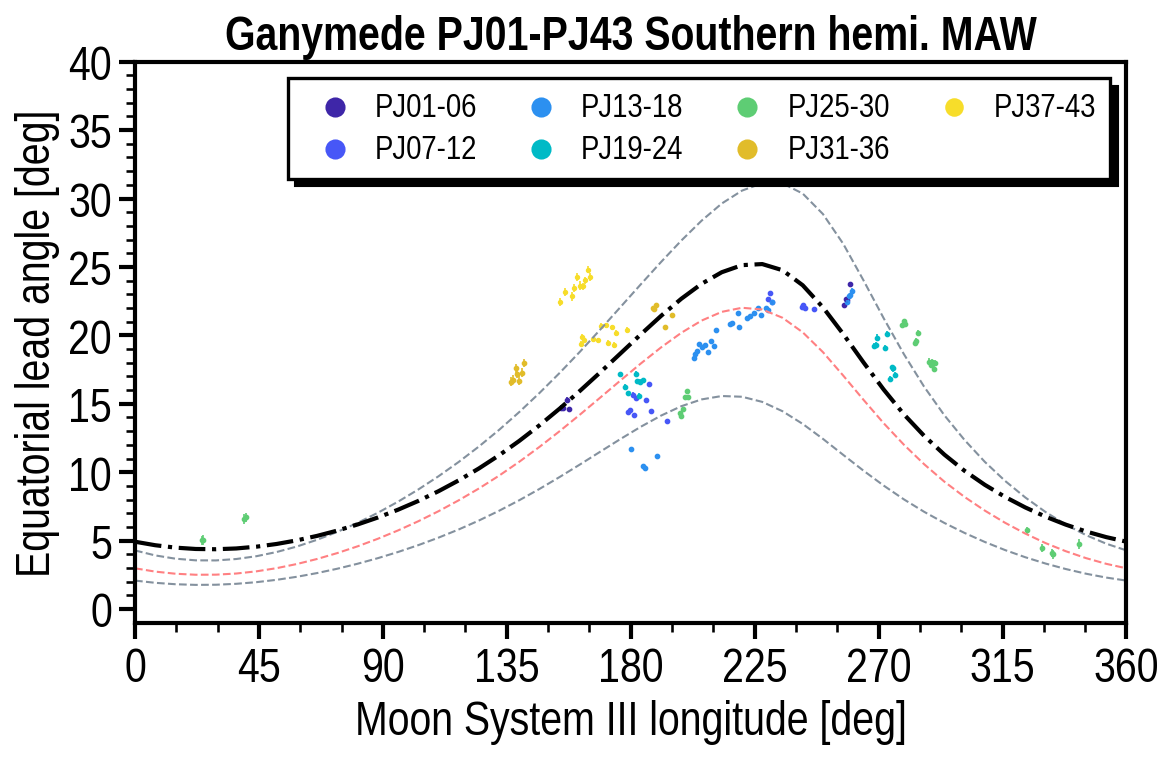

In [23]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8,5), ticksize=1.5,
                dpi='M')
F.initialize()

ymax = 1
if target == 'Io':
    ymax = 12
elif target == 'Europa':
    ymax = 18
elif target == 'Ganymede':
    ymax = 40

F.set_xaxis(label='Moon System III longitude [deg]',
            min=0, max=360,
            ticks=np.arange(0,360+1,45),
            ticklabels=np.arange(0,360+1,45),
            minor_num=3)
F.set_yaxis(ax_idx=0, label='Equatorial lead angle [deg]',
            min=-1, max=ymax,
            ticks=np.arange(0,ymax+1,5),
            ticklabels=np.arange(0,ymax+1,5),
            minor_num=5)

PJ01_06_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr<=6))
pos = PJ01_06_south
sccolor = F._parula_colors()[0]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ01-06')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ07_12_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=7)&(pj_num_arr<=12))
pos = PJ07_12_south
sccolor = F._parula_colors()[40]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ07-12')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ13_18_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=13)&(pj_num_arr<=18))
pos = PJ13_18_south
sccolor = F._parula_colors()[80]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ13-18')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ19_24_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=19)&(pj_num_arr<=24))
pos = PJ19_24_south
sccolor = F._parula_colors()[120]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ19-24')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ25_30_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=25)&(pj_num_arr<=30))
pos = PJ25_30_south
sccolor = F._parula_colors()[160]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ25-30')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ31_36_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=31)&(pj_num_arr<=36))
pos = PJ31_36_south
sccolor = F._parula_colors()[200]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ31-36')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ37_43_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=37)&(pj_num_arr<=43))
pos = PJ37_43_south
sccolor = F._parula_colors()[235]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=2.5, label='PJ37-43')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

F.ax.set_title(fig_title+' Southern hemi. MAW', fontsize=F.fontsize, weight='bold')

# Model calculation
F.ax.plot(n_moon_s3wlon, n_eq_lead_SMAW, 
          linestyle='--', linewidth=1, color=UC.pink)
F.ax.plot(n_moon_s3wlon, n_eq_lead_SMAW_1, 
          linestyle='--', linewidth=1, color=UC.gray)
F.ax.plot(n_moon_s3wlon, n_eq_lead_SMAW_2, 
          linestyle='--', linewidth=1, color=UC.gray)
F.ax.plot(n_moon_s3wlon, n_eq_lead_SMAW_3, 
          linestyle='-.', linewidth=2, color='k')
# F.ax.plot(n_moon_s3wlon, n_eq_lead_SMAW_4, 
#           linestyle='-.', linewidth=1, color=UC.lightblue)

legend = F.legend(ax_idx=0, loc='upper right', ncol=4, markerscale=5, 
                  fontsize_scale=0.7, textcolor=False, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

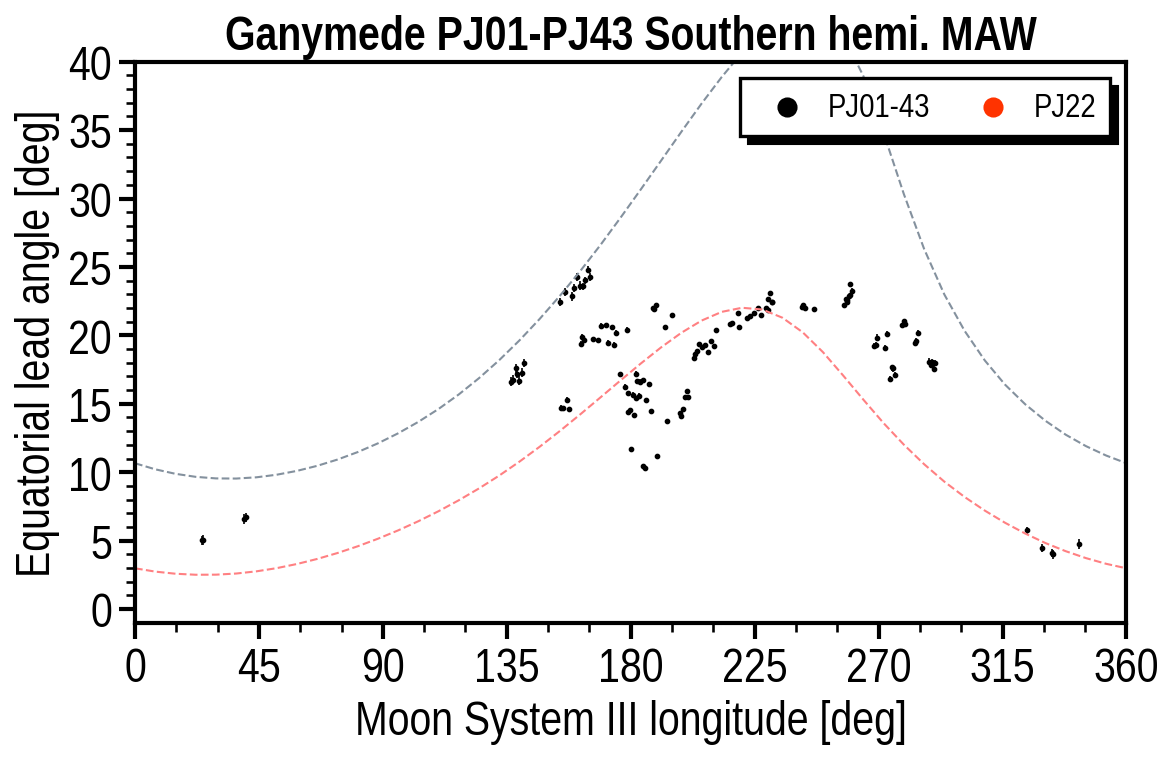

In [24]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8,5), ticksize=1.5,
                dpi='M')
F.initialize()

ymax = 1
if target == 'Io':
    ymax = 12
elif target == 'Europa':
    ymax = 18
elif target == 'Ganymede':
    ymax = 40

F.set_xaxis(label='Moon System III longitude [deg]',
            min=0, max=360,
            ticks=np.arange(0,360+1,45),
            ticklabels=np.arange(0,360+1,45),
            minor_num=3)
F.set_yaxis(ax_idx=0, label='Equatorial lead angle [deg]',
            min=-1, max=ymax,
            ticks=np.arange(0,ymax+1,5),
            ticklabels=np.arange(0,ymax+1,5),
            minor_num=5)

PJ01_04_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=1)&(pj_num_arr<=43))
pos = PJ01_04_south
sccolor = 'k'
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ01-43')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

pj_num = 22
PJ05_08_south = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=pj_num)&(pj_num_arr<=pj_num))
pos = PJ05_08_south
sccolor = UC.red
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ'+str(pj_num).zfill(2))
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

F.ax.set_title(fig_title+' Southern hemi. MAW', fontsize=F.fontsize, weight='bold')

# Model calculation
F.ax.plot(n_moon_s3wlon, n_eq_lead_SMAW, 
          linestyle='--', linewidth=1, color=UC.pink)
F.ax.plot(n_moon_s3wlon, n_eq_lead_SMAW_4, 
          linestyle='--', linewidth=1, color=UC.gray)

legend = F.legend(ax_idx=0, loc='upper right', ncol=4, markerscale=5, 
                  fontsize_scale=0.7, textcolor=False, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

### 北半球 MAW

In [25]:
# Jia & Kivelson (2021)のパラメータ
ni = 4.0     # ion number density [cm-3] range (1-8) (Jia & Kivelson 2021)
Zi = 1.3     # ion average charge                    (Jia & Kivelson 2021)
Ai = 14      # ion mass [amu]                        (Jia & Kivelson 2021)
Ti = 60      # ion temperature [eV]                  (Jia & Kivelson 2021)
Te = 300     # electron temperature [eV]             (Jia & Kivelson 2021)

In [26]:
# 結果初期化
moon_s3wlon = np.radians(np.linspace(-20,380,60))
tau_arr = np.zeros(moon_s3wlon.shape)
mass_dens_arr = np.zeros(moon_s3wlon.shape)
OMGR = 2*np.pi/(Psyn_ga)    # Moon's synodic angular velocity [rad/sec]

# パラメータ調整

# 中心質量密度とスケールハイトのリセット
RHO0 = ni*Ai # [amu cm-3]
HP = Hp0*np.sqrt((Ti/Ai)*(1+Zi*(Te/Ti)))     # [m] (Steffl+2004)
print('Scale height [RJ]:', HP/RJ)

if target=='Io':
    target_RJ = 5.9*RJ
elif target=='Europa':
    target_RJ = 9.38*RJ
elif target=='Ganymede':
    target_RJ = 15.0*RJ

# モデル計算
for i in range(moon_s3wlon.size):
    S0 = LeadA.Awave().tracefield(target_RJ, moon_s3wlon[i])
    tau, theta, Va, mass_dens = LeadA.Awave().tracefield2(target_RJ,
                                                    moon_s3wlon[i],
                                                    S0, 
                                                    RHO0, 
                                                    HP, 
                                                    'N')
    tau_arr[i] = tau
    mass_dens_arr[i] = mass_dens

eq_lead_NMAW = np.degrees(OMGR*tau_arr)

n_moon_s3wlon = np.linspace(0,360,50)  # [deg]
n_eq_lead_NMAW = np.interp(n_moon_s3wlon, np.degrees(moon_s3wlon)+eq_lead_NMAW, eq_lead_NMAW)

Scale height [RJ]: 3.6284589408885815


In [27]:
# 結果初期化
moon_s3wlon = np.radians(np.linspace(-20,380,60))
tau_arr = np.zeros(moon_s3wlon.shape)
mass_dens_arr = np.zeros(moon_s3wlon.shape)
OMGR = 2*np.pi/(Psyn_ga)    # Moon's synodic angular velocity [rad/sec]

# パラメータ調整
ni = 8.0     # ion number density [cm-3] range

# 中心質量密度とスケールハイトのリセット
RHO0 = ni*Ai # [amu cm-3]
HP = Hp0*np.sqrt((Ti/Ai)*(1+Zi*(Te/Ti)))     # [m] (Steffl+2004)
print('Scale height [RJ]:', HP/RJ)

if target=='Io':
    target_RJ = 5.9*RJ
elif target=='Europa':
    target_RJ = 9.38*RJ
elif target=='Ganymede':
    target_RJ = 15.0*RJ

# モデル計算
for i in range(moon_s3wlon.size):
    S0 = LeadA.Awave().tracefield(target_RJ, moon_s3wlon[i])
    tau, theta, Va, mass_dens = LeadA.Awave().tracefield2(target_RJ,
                                                    moon_s3wlon[i],
                                                    S0, 
                                                    RHO0, 
                                                    HP, 
                                                    'N')
    tau_arr[i] = tau
    mass_dens_arr[i] = mass_dens

eq_lead_NMAW = np.degrees(OMGR*tau_arr)

n_moon_s3wlon = np.linspace(0,360,50)  # [deg]
n_eq_lead_NMAW_1 = np.interp(n_moon_s3wlon, np.degrees(moon_s3wlon)+eq_lead_NMAW, eq_lead_NMAW)

Scale height [RJ]: 3.6284589408885815


In [28]:
# 結果初期化
moon_s3wlon = np.radians(np.linspace(-20,380,60))
tau_arr = np.zeros(moon_s3wlon.shape)
mass_dens_arr = np.zeros(moon_s3wlon.shape)
OMGR = 2*np.pi/(Psyn_ga)    # Moon's synodic angular velocity [rad/sec]

# パラメータ調整
ni = 2.0     # ion number density [cm-3] range

# 中心質量密度とスケールハイトのリセット
RHO0 = ni*Ai # [amu cm-3]
HP = Hp0*np.sqrt((Ti/Ai)*(1+Zi*(Te/Ti)))     # [m] (Steffl+2004)
print('Scale height [RJ]:', HP/RJ)

if target=='Io':
    target_RJ = 5.9*RJ
elif target=='Europa':
    target_RJ = 9.38*RJ
elif target=='Ganymede':
    target_RJ = 15.0*RJ

# モデル計算
for i in range(moon_s3wlon.size):
    S0 = LeadA.Awave().tracefield(target_RJ, moon_s3wlon[i])
    tau, theta, Va, mass_dens = LeadA.Awave().tracefield2(target_RJ,
                                                    moon_s3wlon[i],
                                                    S0, 
                                                    RHO0, 
                                                    HP, 
                                                    'N')
    tau_arr[i] = tau
    mass_dens_arr[i] = mass_dens
    
eq_lead_NMAW = np.degrees(OMGR*tau_arr)

n_moon_s3wlon = np.linspace(0,360,50)  # [deg]
n_eq_lead_NMAW_2 = np.interp(n_moon_s3wlon, np.degrees(moon_s3wlon)+eq_lead_NMAW, eq_lead_NMAW)

Scale height [RJ]: 3.6284589408885815


In [29]:
# 結果初期化
moon_s3wlon = np.radians(np.linspace(-20,380,60))
tau_arr = np.zeros(moon_s3wlon.shape)
mass_dens_arr = np.zeros(moon_s3wlon.shape)
OMGR = 2*np.pi/(Psyn_ga)    # Moon's synodic angular velocity [rad/sec]

# パラメータ調整
ni = 10.0     # ion number density [cm-3] range
Ai = 5.6      # ion mass [amu]

# 中心質量密度とスケールハイトのリセット
RHO0 = ni*Ai # [amu cm-3]
HP = Hp0*np.sqrt((Ti/Ai)*(1+Zi*(Te/Ti)))     # [m] (Steffl+2004)
print('Scale height [RJ]:', HP/RJ)

if target=='Io':
    target_RJ = 5.9*RJ
elif target=='Europa':
    target_RJ = 9.38*RJ
elif target=='Ganymede':
    target_RJ = 15.0*RJ

# モデル計算
for i in range(moon_s3wlon.size):
    S0 = LeadA.Awave().tracefield(target_RJ, moon_s3wlon[i])
    tau, theta, Va, mass_dens = LeadA.Awave().tracefield2(target_RJ,
                                                    moon_s3wlon[i],
                                                    S0, 
                                                    RHO0, 
                                                    HP, 
                                                    'N',)
    tau_arr[i] = tau
    mass_dens_arr[i] = mass_dens

eq_lead_NMAW = np.degrees(OMGR*tau_arr)

n_moon_s3wlon = np.linspace(0,360,50)  # [deg]
n_eq_lead_NMAW_3 = np.interp(n_moon_s3wlon, np.degrees(moon_s3wlon)+eq_lead_NMAW, eq_lead_NMAW)

Scale height [RJ]: 5.737097324805089


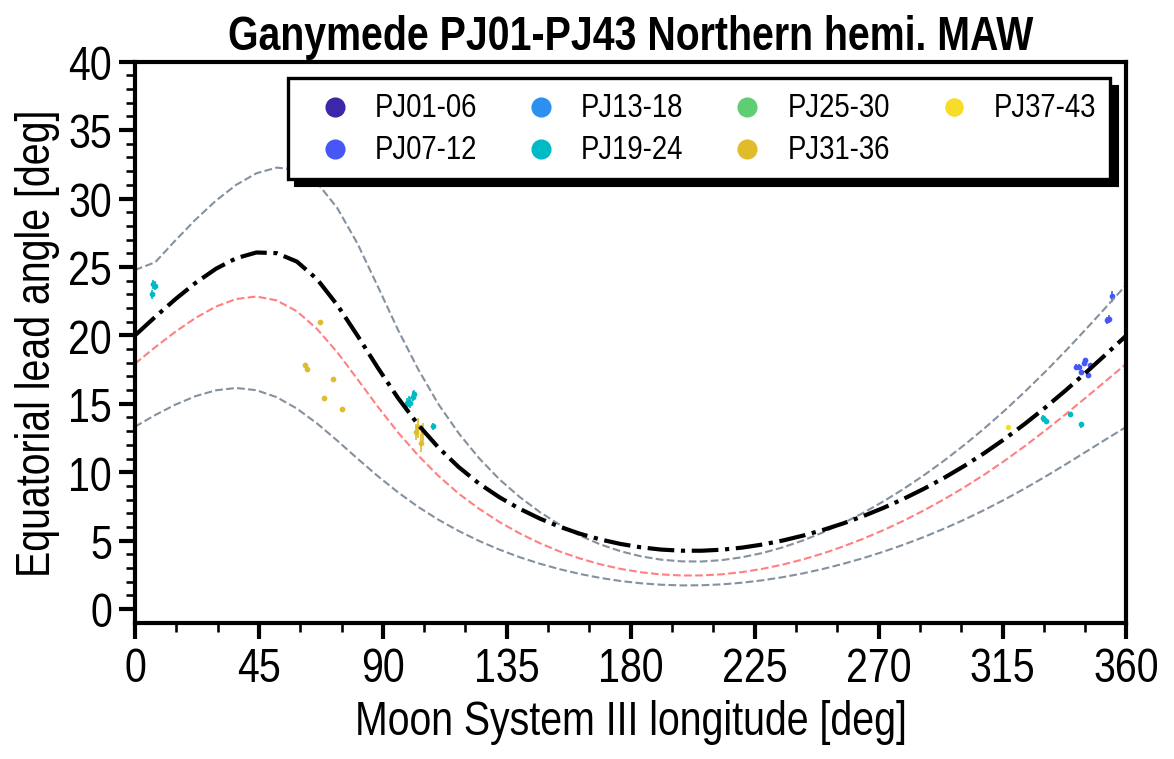

In [30]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8,5), ticksize=1.5,
                dpi='M')
F.initialize()

ymax = 1
if target == 'Io':
    ymax = 12
elif target == 'Europa':
    ymax = 18
elif target == 'Ganymede':
    ymax = 40

F.set_xaxis(label='Moon System III longitude [deg]',
            min=0, max=360,
            ticks=np.arange(0,360+1,45),
            ticklabels=np.arange(0,360+1,45),
            minor_num=3)
F.set_yaxis(ax_idx=0, label='Equatorial lead angle [deg]',
            min=-1, max=ymax,
            ticks=np.arange(0,ymax+1,5),
            ticklabels=np.arange(0,ymax+1,5),
            minor_num=5)

PJ01_06_north = np.where((np.array(hemisphere_arr)==b'North')&(pj_num_arr<=6))
pos = PJ01_06_north
sccolor = F._parula_colors()[0]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ01-06')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ07_12_north = np.where((np.array(hemisphere_arr)==b'North')&(pj_num_arr>=7)&(pj_num_arr<=12))
pos = PJ07_12_north
sccolor = F._parula_colors()[40]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ07-12')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ13_18_north = np.where((np.array(hemisphere_arr)==b'North')&(pj_num_arr>=13)&(pj_num_arr<=18))
pos = PJ13_18_north
sccolor = F._parula_colors()[80]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ13-18')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ19_24_north = np.where((np.array(hemisphere_arr)==b'North')&(pj_num_arr>=19)&(pj_num_arr<=24))
pos = PJ19_24_north
sccolor = F._parula_colors()[120]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ19-24')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ25_30_north = np.where((np.array(hemisphere_arr)==b'North')&(pj_num_arr>=25)&(pj_num_arr<=30))
pos = PJ25_30_north
sccolor = F._parula_colors()[160]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ25-30')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ31_36_north = np.where((np.array(hemisphere_arr)==b'North')&(pj_num_arr>=31)&(pj_num_arr<=36))
pos = PJ31_36_north
sccolor = F._parula_colors()[200]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, label='PJ31-36')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

PJ37_43_north = np.where((np.array(hemisphere_arr)==b'North')&(pj_num_arr>=37)&(pj_num_arr<=43))
pos = PJ37_43_north
sccolor = F._parula_colors()[235]
F.ax.scatter(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=2.5, label='PJ37-43')
F.ax.errorbar(moon_s3long_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

F.ax.set_title(fig_title+' Northern hemi. MAW', fontsize=F.fontsize, weight='bold')

# Model calculation
F.ax.plot(n_moon_s3wlon, n_eq_lead_NMAW, 
          linestyle='--', linewidth=1, color=UC.pink)
F.ax.plot(n_moon_s3wlon, n_eq_lead_NMAW_1, 
          linestyle='--', linewidth=1, color=UC.gray)
F.ax.plot(n_moon_s3wlon, n_eq_lead_NMAW_2, 
          linestyle='--', linewidth=1, color=UC.gray)
F.ax.plot(n_moon_s3wlon, n_eq_lead_NMAW_3, 
          linestyle='-.', linewidth=2, color='k')

legend = F.legend(ax_idx=0, loc='upper right', ncol=4, markerscale=5, 
                  fontsize_scale=0.7, textcolor=False, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

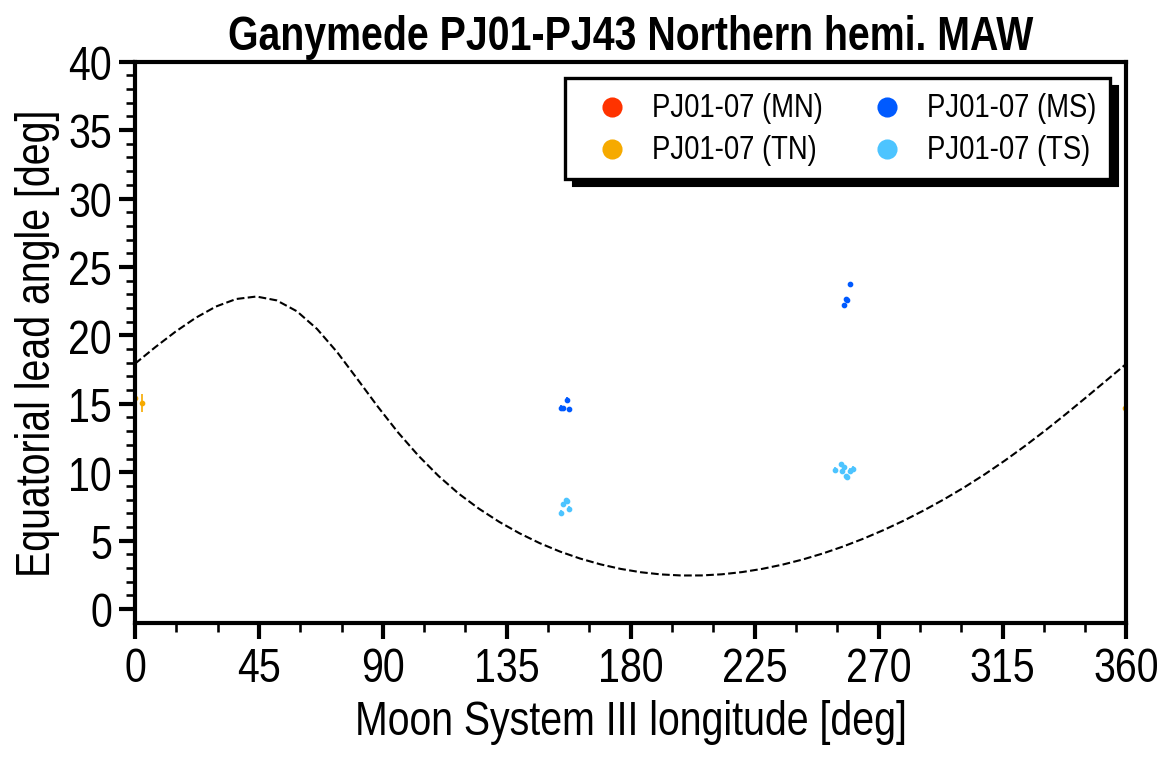

In [81]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8,5), ticksize=1.5,
                dpi='M')
F.initialize()

ymax = 1
if target == 'Io':
    ymax = 12
elif target == 'Europa':
    ymax = 18
elif target == 'Ganymede':
    ymax = 40

F.set_xaxis(label='Moon System III longitude [deg]',
            min=0, max=360,
            ticks=np.arange(0,360+1,45),
            ticklabels=np.arange(0,360+1,45),
            minor_num=3)
F.set_yaxis(ax_idx=0, label='Equatorial lead angle [deg]',
            min=-1, max=ymax,
            ticks=np.arange(0,ymax+1,5),
            ticklabels=np.arange(0,ymax+1,5),
            minor_num=5)

PJnum0 = 1
PJnum1 = 7
PJpos = np.where((np.array(hemisphere_arr)==b'North')&(pj_num_arr>=PJnum0)&(pj_num_arr<=PJnum1))
pos = PJpos
sccolor = UC.red
F.ax.scatter(moon_s3long_M_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, 
             label='PJ'+str(PJnum0).zfill(2)+'-'+str(PJnum1).zfill(2)+' (MN)')
F.ax.errorbar(moon_s3long_M_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)
sccolor = UC.orange
F.ax.scatter(moon_s3long_T_arr[pos], d_TEB_eq_arr[pos], 
             color=sccolor, s=3.0, 
             label='PJ'+str(PJnum0).zfill(2)+'-'+str(PJnum1).zfill(2)+' (TN)')
F.ax.errorbar(moon_s3long_T_arr[pos], d_TEB_eq_arr[pos], 
              yerr=np.array([d_TEB_eq_arr_0[pos], 
                             d_TEB_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)
PJpos = np.where((np.array(hemisphere_arr)==b'South')&(pj_num_arr>=PJnum0)&(pj_num_arr<=PJnum1))
pos = PJpos
sccolor = UC.blue
F.ax.scatter(moon_s3long_M_arr[pos], d_MAW_eq_arr[pos], 
             color=sccolor, s=3.0, 
             label='PJ'+str(PJnum0).zfill(2)+'-'+str(PJnum1).zfill(2)+' (MS)')
F.ax.errorbar(moon_s3long_M_arr[pos], d_MAW_eq_arr[pos], 
              yerr=np.array([d_MAW_eq_arr_0[pos], 
                             d_MAW_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)
sccolor = UC.lightblue
F.ax.scatter(moon_s3long_T_arr[pos], d_TEB_eq_arr[pos], 
             color=sccolor, s=3.0, 
             label='PJ'+str(PJnum0).zfill(2)+'-'+str(PJnum1).zfill(2)+' (TS)')
F.ax.errorbar(moon_s3long_T_arr[pos], d_TEB_eq_arr[pos], 
              yerr=np.array([d_TEB_eq_arr_0[pos], 
                             d_TEB_eq_arr_1[pos]]),
              linewidth=0., markersize=0,
              elinewidth=0.8, color=sccolor)

F.ax.set_title(fig_title+' Northern hemi. MAW', fontsize=F.fontsize, weight='bold')

# Model calculation
F.ax.plot(n_moon_s3wlon, n_eq_lead_NMAW, 
          linestyle='--', linewidth=1, color='k')

legend = F.legend(ax_idx=0, loc='upper right', ncol=2, markerscale=5, 
                  fontsize_scale=0.7, textcolor=False, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

2025/3/6 メモ

MAWとTEBが両方出ている日付のデータしか表示されないのはなぜ？